In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from pathlib import Path

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.diagnostics import hpdi

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.baseline import Baseline
from hb_mep.models.utils import Site as site
# from hb_mep.models.mixed_effects_human import MixedEffectsHuman
from hb_mep.utils import plot, timing
from hb_mep.utils.constants import (
    INTENSITY,
    RESPONSE,
    PARTICIPANT,
    FEATURES
)

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [4]:
def get_combinations(self, df: pd.DataFrame):
    combinations = \
        df \
        .groupby(by=self.columns) \
        .size() \
        .to_frame("counts") \
        .reset_index().copy()
    combinations = combinations[self.columns].apply(tuple, axis=1).tolist()
    return combinations

In [5]:
# def get_estimates(
#     self,
#     posterior_samples: dict,
#     posterior_means: dict,
#     c: tuple
# ):
#     a = posterior_means[site.a][c[::-1]]
#     b = posterior_means[site.b][c[::-1]]
#     lo = posterior_means[site.lo][c[::-1]]
#     # l = posterior_means["l"][c[::-1]]
#     h = posterior_means["h"][c[::-1]]
#     # r = posterior_means["r"][c[::-1]]
#     # q = posterior_means["q"][c[::-1]]
#     # v = posterior_means["v"][c[::-1]]

#     y = lo + \
#     jnp.maximum(
#         0,
#         -1 + \
#         (h + 1) / \
#         (1 + h * jnp.exp(-b * (self.x - a)))
#     )

#     return y

# def plot_fit(self, df: pd.DataFrame, posterior_samples: dict, encoder_dict: dict = None):
#     combinations = get_combinations(self, df)
#     n_combinations = len(combinations)

#     posterior_means = {
#         p:posterior_samples[p].mean(axis=0) for p in posterior_samples
#     }

#     fig, ax = plt.subplots(
#         n_combinations,
#         2,
#         figsize=(12, n_combinations * 3),
#         constrained_layout=True
#     )

#     for i, c in enumerate(combinations):
#         idx = df[self.columns].apply(tuple, axis=1).isin([c])
#         temp_df = df[idx].reset_index(drop=True).copy()

#         sns.scatterplot(data=temp_df, x=INTENSITY, y=RESPONSE, ax=ax[i, 0])
#         sns.scatterplot(data=temp_df, x=INTENSITY, y=RESPONSE, ax=ax[i, 1], alpha=.4)

#         y = get_estimates(
#             self, posterior_samples, posterior_means, c
#         )

#         sns.lineplot(
#             x=self.x,
#             y=y,
#             ax=ax[i, 1],
#             color="red",
#             alpha=0.4,
#             label=f"Mean Posterior"
#         )

#         ax[i, 1].set_xlim(right=temp_df[INTENSITY].max() + 3)

#         if encoder_dict is None:
#             title = f"{tuple(self.columns)} - {c}"
#         else:
#             c0 = encoder_dict["participant"].inverse_transform(np.array([c[0]]))[0]
#             c1 = temp_df["sc_level"].unique()[0]
#             c2 = encoder_dict["method"].inverse_transform(np.array([c[1]]))[0]

#             title = f"({c0}, {c1}, {c2})"

#         ax[i, 0].set_title(title)

#         ax[i, 1].set_title(f"Model Fit")
#         ax[i, 1].legend(loc="upper left")

#     return fig


In [6]:
def get_estimates(
    self,
    posterior_samples: dict,
    posterior_means: dict,
    c: tuple
):
    a = posterior_means[site.a][c[::-1]]
    b = posterior_means[site.b][c[::-1]]
    lo = posterior_means[site.lo][c[::-1]]
    # l = posterior_means["l"][c[::-1]]
    h = posterior_means["h"][c[::-1]]
    # r = posterior_means["r"][c[::-1]]
    # q = posterior_means["q"][c[::-1]]
    v = posterior_means["v"][c[::-1]]

    # y = lo + \
    # jnp.maximum(
    #     0,
    #     -1 + \
    #     (h + 1) / \
    #     (1 + h * jnp.exp(-b * (self.x - a)))
    # )

    y = lo + \
    jnp.maximum(
        0,
        -1 + \
        (h + 1) / \
        jnp.power(
            1 + \
            (jnp.power(1 + h, v) - 1) * \
            jnp.exp(-b * (self.x - a)),
            1 / v
        )
    )

    threshold_samples = posterior_samples[site.a][:, c[1], c[0]]
    hpdi_interval = hpdi(threshold_samples, prob=0.95)

    return y, threshold_samples, hpdi_interval

def plot_fit(self, df: pd.DataFrame, posterior_samples: dict, encoder_dict: dict = None):
    combinations = get_combinations(self, df)
    n_combinations = len(combinations)

    posterior_means = {
        p:posterior_samples[p].mean(axis=0) for p in posterior_samples
    }

    fig, ax = plt.subplots(
        n_combinations,
        3,
        figsize=(12, n_combinations * 3),
        constrained_layout=True
    )

    for i, c in enumerate(combinations):
        idx = df[self.columns].apply(tuple, axis=1).isin([c])
        temp_df = df[idx].reset_index(drop=True).copy()

        sns.scatterplot(data=temp_df, x=INTENSITY, y=RESPONSE, ax=ax[i, 0])
        sns.scatterplot(data=temp_df, x=INTENSITY, y=RESPONSE, ax=ax[i, 1], alpha=.4)

        y, threshold_samples, hpdi_interval = get_estimates(
            self, posterior_samples, posterior_means, c
        )

        sns.kdeplot(x=threshold_samples, ax=ax[i, 1], color="blue")
        sns.lineplot(
            x=self.x,
            y=y,
            ax=ax[i, 1],
            color="red",
            alpha=0.4,
            label=f"Mean Posterior"
        )
        sns.kdeplot(x=threshold_samples, color="blue", ax=ax[i, 2])

        ax[i, 2].axvline(hpdi_interval[0], linestyle="--", color="green", label="95% HPDI Interval")
        ax[i, 2].axvline(hpdi_interval[1], linestyle="--", color="green")

        ax[i, 1].set_xlim(left=-2, right=temp_df[INTENSITY].max() + 3)

        if encoder_dict is None:
            title = f"{tuple(self.columns)} - {c}"
        else:
            c0 = encoder_dict["participant"].inverse_transform(np.array([c[0]]))[0]
            c1 = temp_df["sc_level"].unique()[0]
            c2 = encoder_dict["method"].inverse_transform(np.array([c[1]]))[0]

            title = f"({c0}, {c1}, {c2})"

        ax[i, 2].set_xlim(left=hpdi_interval[0] - 3, right=hpdi_interval[1] + 3)

        ax[i, 0].set_title(title)

        ax[i, 1].set_title(f"Model Fit")
        ax[i, 2].set_title(f"Threshold Estimate")
        ax[i, 1].legend(loc="upper left")
        ax[i, 2].legend(loc="upper left")

    return fig

In [7]:
data = DataClass(config)

DATASET_REAL = 'real_data/dnc_info_2022-05-26.parquet'
DATASET_REAL_METADATA = 'dnc_info_2022-05-26_settings.json'

df = pd.read_parquet(os.path.join(data.data_path, DATASET_REAL))
df = data.clean_human_data(df, muscle="Triceps")

# participants = ["cornptio012", "cornptio013", "cornptio015", "scapptio001"]
# idx = df.participant.isin(participants)
# df = df[idx].reset_index(drop=True).copy()

# df = df[df.participant.isin(["scapptio001", "cornptio017"])].copy()
# df = df[df.participant.isin(["cornptio017"])].copy()


df, encoder_dict = data.build(df)

2023-05-19 10:36:00,489 - hb_mep.utils.utils - INFO - func:clean_human_data took: 0.09 sec
2023-05-19 10:36:00,490 - hb_mep.data_access.core - INFO - Processing data ...
2023-05-19 10:36:00,500 - hb_mep.utils.utils - INFO - func:preprocess took: 0.01 sec
2023-05-19 10:36:00,500 - hb_mep.utils.utils - INFO - func:build took: 0.01 sec


#### Plot

In [8]:
# plot(df=df, encoder_dict=encoder_dict);

#### Initialize model

In [9]:
class Generalized_Logistic(Baseline):
    def __init__(self, config: HBMepConfig):
        super(Generalized_Logistic, self).__init__(config=config)
        self.name = "Generalized_Logistic"

        self.columns = ["participant", "method"]
        self.x = np.linspace(0, 15, 100)

    def _model(self, intensity, participant, feature1, response_obs=None):
        n_participant = np.unique(participant).shape[0]
        n_feature1 = np.unique(feature1).shape[0]

        a_mean_global_mean = numpyro.sample(
            "a_mean_global_mean",
            dist.HalfNormal(2.0)
        )
        a_scale_global_scale = numpyro.sample(
            "a_scale_global_scale",
            dist.HalfNormal(2.0)
        )

        a_scale = numpyro.sample(
            site.a_scale,
            dist.HalfNormal(a_scale_global_scale)
        )
        a_mean = numpyro.sample(
            site.a_mean,
            dist.TruncatedDistribution(dist.Normal(a_mean_global_mean, a_scale), low=0)
        )

        # Slope
        b_mean_global_scale = numpyro.sample(site.b_mean_global_scale, dist.HalfNormal(10.0))
        b_scale_global_scale = numpyro.sample(site.b_scale_global_scale, dist.HalfNormal(2.0))

        b_mean = numpyro.sample(site.b_mean, dist.HalfNormal(b_mean_global_scale))
        b_scale = numpyro.sample(site.b_scale, dist.HalfNormal(b_scale_global_scale))

        h_scale_global_scale = numpyro.sample("h_scale_global_scale", dist.HalfNormal(10.0))
        h_scale = numpyro.sample("h_scale", dist.HalfNormal(h_scale_global_scale))

        v_scale_global_scale = numpyro.sample("v_scale_global_scale", dist.HalfNormal(10.0))
        v_scale = numpyro.sample("v_scale", dist.HalfNormal(v_scale_global_scale))

        # lo_scale_global_scale = numpyro.sample(site.lo_scale_global_scale, dist.HalfNormal(2.0))
        # lo_scale = numpyro.sample(site.lo_scale, dist.HalfNormal(lo_scale_global_scale))

        with numpyro.plate("n_participant", n_participant, dim=-1):
            """ Priors """
            with numpyro.plate("n_feature1", n_feature1, dim=-2):
                a = numpyro.sample(
                    site.a,
                    dist.TruncatedDistribution(dist.Normal(a_mean, a_scale), low=0)
                )

                b = numpyro.sample(
                    site.b,
                    dist.TruncatedDistribution(dist.Normal(b_mean, b_scale), low=0)
                )

                # h = numpyro.sample("h", dist.HalfNormal(10.0))
                h = numpyro.sample("h", dist.HalfNormal(h_scale))

                # v = numpyro.sample("v", dist.HalfNormal(5.0))
                v = numpyro.sample("v", dist.HalfNormal(v_scale))

                lo = numpyro.sample(site.lo, dist.HalfNormal(2.0))

                # Noise
                noise_offset = numpyro.sample(
                    "noise_offset",
                    dist.HalfCauchy(0.5)
                )
                noise_slope = numpyro.sample(
                    "noise_slope",
                    dist.HalfCauchy(0.5)
                )

        # mean = numpyro.deterministic(
        #     site.mean,
        #     jnp.maximum(
        #         lo[feature1, participant],
        #         l[feature1, participant] + \
        #         (h[feature1, participant] - l[feature1, participant]) / \
        #         (1 + jnp.exp(-b[feature1, participant] * intensity))
        #     )
        # )

        # mean = numpyro.deterministic(
        #     site.mean,
        #     l[feature1, participant] + \
        #     (h[feature1, participant] - l[feature1, participant]) / \
        #     (
        #         1 + jnp.exp(-b[feature1, participant] * (intensity - a[feature1, participant]))
        #     )
        # )

        mean = numpyro.deterministic(
            site.mean,
            lo[feature1, participant] + \
            jnp.maximum(
                0,
                -1 + \
                (h[feature1, participant] + 1) / \
                jnp.power(
                    1 + \
                    (jnp.power(1 + h[feature1, participant], v[feature1, participant]) - 1) * \
                    jnp.exp(-b[feature1, participant] * (intensity - a[feature1, participant])),
                    1 / v[feature1, participant]
                )
            )
        )

        # mean = numpyro.deterministic(
        #     site.mean,
        #     lo[feature1, participant] + \
        #     jnp.maximum(
        #         0,
        #         -1 + \
        #         (h[feature1, participant] + 1) / \
        #         (
        #             1 + jnp.exp(-b[feature1, participant] * (intensity - a[feature1, participant]))
        #         )
        #     )
        # )

        sigma = numpyro.deterministic(
            "sigma",
            noise_offset[feature1, participant] + \
            noise_slope[feature1, participant] * mean
        )

        # penalty = 5 * (jnp.fabs(h - l) - (h - l))
        # numpyro.factor(site.penalty, -penalty)

        # penalty2 = 5 * (jnp.fabs(lo - l) - (lo - l))
        # numpyro.factor("penalty2", -penalty2)

        with numpyro.plate("data", len(intensity)):
            return numpyro.sample("obs", dist.TruncatedNormal(mean, sigma, low=0), obs=response_obs)

    @timing
    def run_inference(self, df: pd.DataFrame) -> tuple[numpyro.infer.mcmc.MCMC, dict]:
        """
        Run MCMC inference
        """
        response = df[RESPONSE].to_numpy().reshape(-1,)
        participant = df[PARTICIPANT].to_numpy().reshape(-1,)
        feature1 = df[FEATURES[1]].to_numpy().reshape(-1,)
        intensity = df[INTENSITY].to_numpy().reshape(-1,)

        # MCMC
        nuts_kernel = NUTS(self._model)
        mcmc = MCMC(nuts_kernel, **self.config.MCMC_PARAMS)
        rng_key = jax.random.PRNGKey(self.random_state)
        mcmc.run(rng_key, intensity, participant, feature1, response)
        posterior_samples = mcmc.get_samples()

        return mcmc, posterior_samples

In [10]:
model = Generalized_Logistic(config)

#### Run MCMC inference

In [11]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-05-19 10:36:00,936 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-05-19 10:36:00,936 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-19 10:36:00,937 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-19 10:36:00,938 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-05-19 10:36:00,938 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-19 10:46:28,043 - hb_mep.utils.utils - INFO - func:run_inference took: 10 min and 27.11 sec


#### Diagnostics

In [12]:
mcmc.print_summary(prob=.95)


                            mean       std    median      2.5%     97.5%     n_eff     r_hat
                a[0,0]      3.70      1.79      3.62      0.33      6.64   5712.79      1.00
                a[0,1]      1.39      0.09      1.38      1.23      1.57   6631.27      1.00
                a[0,2]      3.34      1.38      3.76      0.37      5.48   1615.92      1.00
                a[0,3]      4.33      0.40      4.37      3.40      5.23   1863.38      1.00
                a[0,4]      5.86      0.98      5.70      4.35      7.92   9509.58      1.00
                a[0,5]      5.01      3.07      4.96      0.02      9.75   2124.73      1.00
                a[0,6]      3.15      0.14      3.13      2.91      3.44  11816.39      1.00
                a[0,7]      1.85      0.25      1.86      1.38      2.37   5984.61      1.00
                a[0,8]      1.97      0.04      1.96      1.90      2.06   2830.57      1.00
                a[0,9]      1.72      0.08      1.73      1.57      1

In [12]:
mcmc.print_summary(prob=.95)


                            mean       std    median      2.5%     97.5%     n_eff     r_hat
                a[0,0]      3.73      1.77      3.66      0.37      6.70   5744.11      1.00
                a[0,1]      1.39      0.09      1.39      1.23      1.57   3771.07      1.00
                a[0,2]      3.32      1.35      3.75      0.43      5.43   2515.24      1.00
                a[0,3]      4.33      0.40      4.38      3.47      5.28   1228.68      1.00
                a[0,4]      5.88      0.99      5.73      4.31      7.92   6950.04      1.00
                a[0,5]      5.28      3.05      5.51      0.00      9.84   2420.46      1.00
                a[0,6]      3.15      0.14      3.12      2.90      3.42   7246.51      1.00
                a[0,7]      1.85      0.25      1.85      1.37      2.35   2588.64      1.00
                a[0,8]      1.97      0.04      1.96      1.91      2.06   3303.26      1.00
                a[0,9]      1.72      0.08      1.73      1.55      1

#### Information Criterion

In [41]:
import arviz as az

numpyro_data = az.from_numpyro(mcmc)

In [44]:
az.loo(numpyro_data)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 1165 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   952.31    88.24
p_loo      203.88        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1108   95.1%
 (0.5, 0.7]   (ok)         29    2.5%
   (0.7, 1]   (bad)        16    1.4%
   (1, Inf)   (very bad)   12    1.0%

In [45]:
az.waic(numpyro_data)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 1165 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   973.83    86.78
p_waic      182.36        -

There has been a warning during the calculation. Please check the results.

#### Plot fitted curves

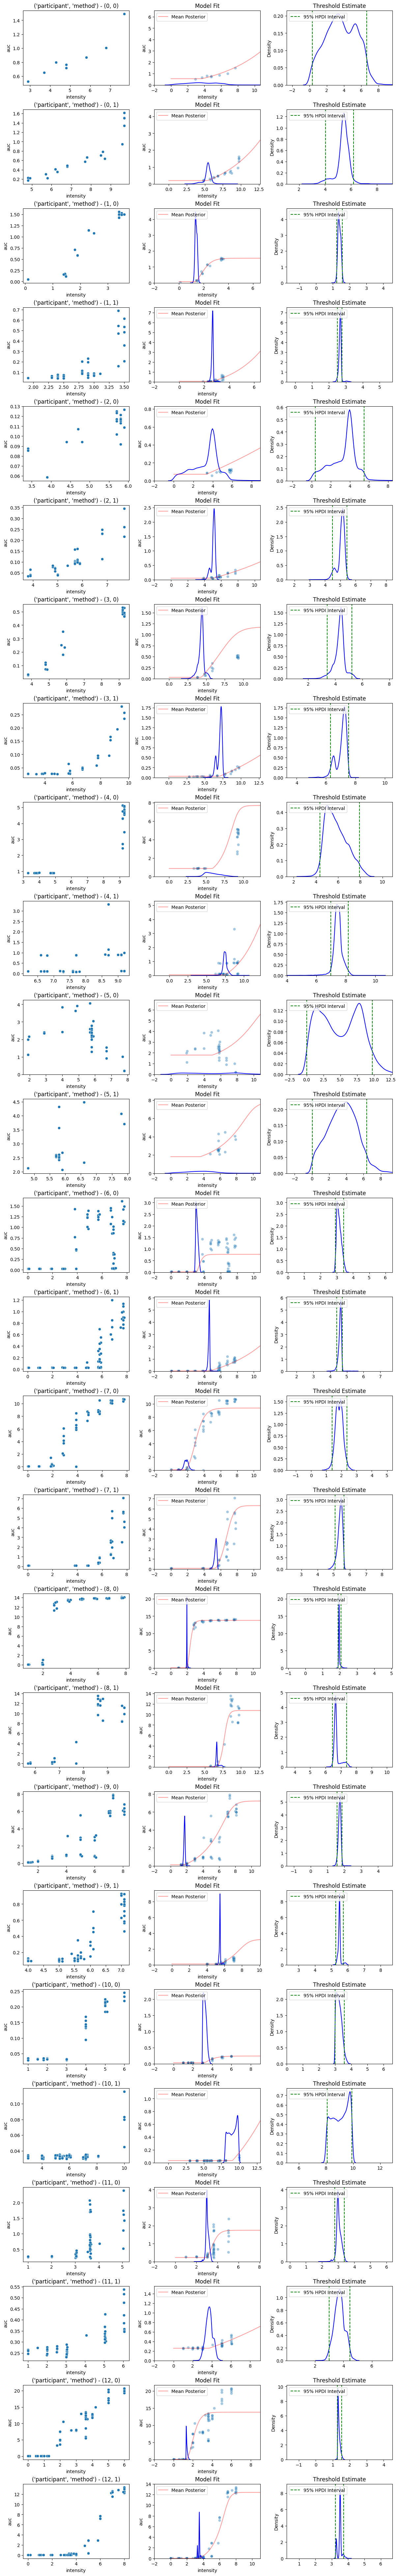

In [13]:
plot_fit(model, df=df, posterior_samples=posterior_samples);

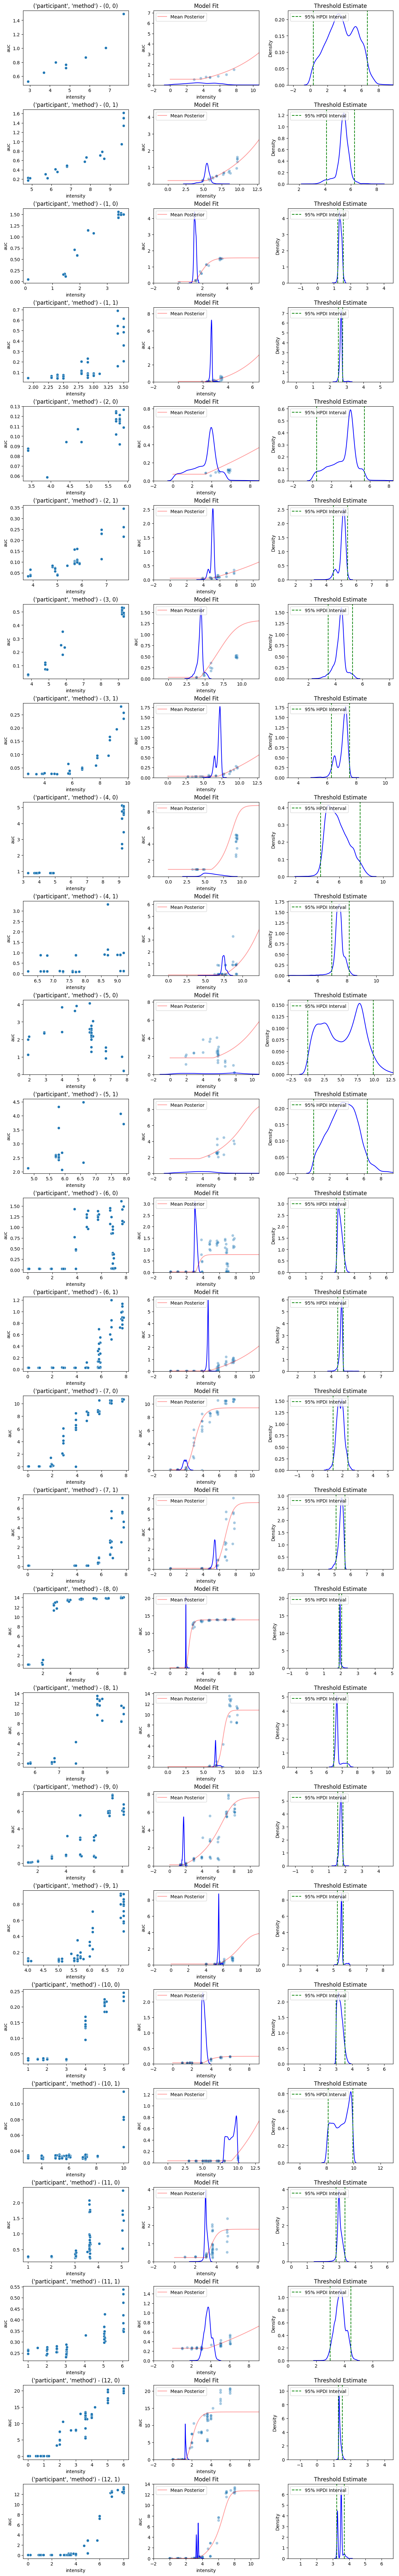

In [13]:
plot_fit(model, df=df, posterior_samples=posterior_samples);

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

samples = posterior_samples["delta_mean"]
pr = (samples > 0).mean()

sns.kdeplot(samples)
plt.title(f"$\Pr (delta > 0) = {pr : .04}$")
plt.xlabel(f"$delta = Midline - Lateral$");

KeyError: 'delta_mean'